## <center>Plant Disease Detection</center>

This notebook contains code for training a deep learning based model using tensorflow for detecting diseases in plants.

The model is created through the transfer learning with Mobilenet V2 model. The dataset consists of 87,000 images of plant leaves with diseases, span over 38 classes.

<h1 style='color: #8532a8; font-family: Segoe UI; font-size: 1.5em; font-weight: 300; font-size: 24px'>If you found this notebook useful, kindly leave an upvote!</h1>

In [1]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [3]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

## Load Image data

We will be loading all the images in the dataset and apply augmentations to make the model prepared for all kinds of images.

The Tensorflow and Keras API provides `ImageDataGenerator` for adding the augmentations to be applied to the images, and easily load them from the directory. This automatically keeps track of the class for each image and works seamlessly with the rest of the API.

In [4]:
dataset_root = "/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"

train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "valid")

In [5]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.


In [6]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())

In [7]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 17572 images belonging to 38 classes.


## Model building and Training

As mentioned above, We will be performing Transfer learning with Mobilenet V2 model.

We get the model with pre-trained weights through API without the Top layer, and Then stack further layers for prediction.

We used Global Average 2D Pooling for normalization along with dropout, and the final Dense output layer for the prediction.

In [8]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

9412608/9406464 [==============================] - 1s 0us/step


In [9]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 38)                48678     
Total params: 2,306,662
Trainable params: 48,678
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [11]:
# Num epochs
epochs = 30

# Train model
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
150/150 [==============================] - 99s 605ms/step - loss: 2.8357 - accuracy: 0.2774
Epoch 2/30
150/150 [==============================] - 90s 597ms/step - loss: 0.9643 - accuracy: 0.7456
Epoch 3/30
150/150 [==============================] - 86s 571ms/step - loss: 0.7128 - accuracy: 0.7908
Epoch 4/30
150/150 [==============================] - 84s 563ms/step - loss: 0.5547 - accuracy: 0.8397
Epoch 5/30
150/150 [==============================] - 82s 549ms/step - loss: 0.5355 - accuracy: 0.8439
Epoch 6/30
150/150 [==============================] - 81s 539ms/step - loss: 0.4925 - accuracy: 0.8490
Epoch 7/30
150/150 [==============================] - 80s 535ms/step - loss: 0.4374 - accuracy: 0.8634
Epoch 8/30
150/150 [==============================] - 78s 520ms/step - loss: 0.4297 - accuracy: 0.8663
Epoch 9/30
150/150 [==============================] - 76s 508ms/step - loss: 0.3940 - accuracy: 0.8755
Epoch 10/30
150/150 [==============================] - 75s 503ms/step - l

In [12]:
model.evaluate(test_data)

550/550 [==============================] - 183s 333ms/step - loss: 0.2428 - accuracy: 0.9212


[0.24283833801746368, 0.921238362789154]

## Visualize the model history

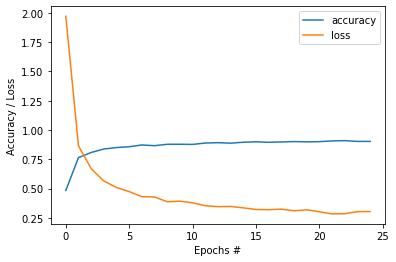

In [13]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

## Save and download the model

We save the model to a file, and link it using IPython to easily get the assets.

In [14]:
model.save("plant_disease_detection.h5")

In [15]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./plant_disease_detection.h5")

/kaggle/working/plant_disease_detection.h5

In [16]:
# Dump the categories
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)

# Link categories JSON
FileLink("categories.json")

/kaggle/working/categories.json